# Machine Learning

#### Imports

In [33]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import lightgbm as lgbm

import pickle

pd.set_option('display.max_columns', None)

## Carregar base de dados

In [78]:
PATH = '../data/processed/'

In [79]:
dataset = pd.read_csv(os.path.join(PATH, 'dataset.csv'), sep=',')
print(dataset.shape)
dataset.head()

(4748, 93)


,BOM,RUIM,DESEMPENHO_ESC,CD_ESCOLA,CAPITAL,AREA,ESTIMATED_POP,RURAL_URBAN,GVA_PUBLIC,GVA_TOTAL,GDP,GDP_CAPITA,COMP_H,COMP_O,COMP_P,COMP_Q,CLUSTER,DEPENDENCIAS_SALAS_AULA,DEPENDENCIAS_SALA_RECURSO,DEPENDENCIAS_TOT_SALAS_AULA,DEPENDENCIAS_CANTINA,DEPENDENCIAS_COPA,DEPENDENCIAS_REFEITORIO,DEPENDENCIAS_SALA_LEITURA,DEPENDENCIAS_TOT_SALA_LEITURA,DEPENDENCIAS_TOT_QUADRA,DEPENDENCIAS_SALA_PROF,DEPENDENCIAS_PATIO_COBERTO,DEPENDENCIAS_PATIO_DESCOBERTO,DEPENDENCIAS_TOT_VESTIARIO,DEPENDENCIAS_LAB_INFO,DEPENDENCIAS_LAB_CIENCIAS,DEPENDENCIAS_LAB_CIENCIA_FISICA_BIOLOGICA,DEPENDENCIAS_TOT_LAB_CIENCIA,DEPENDENCIAS_LAB_MULTIUSO,DEPENDENCIAS_OFICINA,DEPENDENCIAS_DORMITORIO,DEPENDENCIAS_SANITARIO_ADEQ_DEF,DEPENDENCIAS_SANITARIO_AL_MASC,DEPENDENCIAS_SANITARIO_AL_FEM,DEPENDENCIAS_TOT_SANITARIO_AL,DEPENDENCIAS_TOT_SANITARIO_FUNC,DEPENDENCIAS_DEPEND_ADEQ_DEF,DEPENDENCIAS_SALA_ED_FISICA,DEPENDENCIAS_SALA_PROG_ESC_FAMILIA,DEPENDENCIAS_BRINQUEDOTECA,DEPENDENCIAS_SALA_REFORCO,DEPENDENCIAS_AREA_SERVICO,DEPENDENCIAS_SALA_ATENDIMENTO,DEPENDENCIAS_SALA_ENTRETENIMENTO,FORMACAO_APERF/EXTENSIAOCULTURAL,FORMACAO_BACHARELADO/TECNIOLOGO,FORMACAO_DOUTORADO,FORMACAO_ENSINO_MEDIO,FORMACAO_ESPECIALIZACAO,FORMACAO_LICENCIATURA,FORMACAO_MESTRADO,FORMACAO_S/INFO,QTD_SERVIDORES,QTD_PROFESSORES,MEDIA_FORMACOES,QTD_FORMACAO_CONTINUADA,QTD_CARGOS_DISTINTOS,QTD_TOTAL_ALUNOS,QTD_CLASSES,MEDIA_ALUNOS_SALA,STD_ALUNOS_SALA,QTD_CLASSE_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_CLASSE_TIPO_ENSINO MEDIO,QTD_CLASSE_TIPO_CEL,QTD_ALUNOS_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_ALUNOS_TIPO_ENSINO MEDIO,QTD_ALUNOS_TIPO_CEL,JORNADA_QTD_DISCIPLINAS_mean,JORNADA_QTD_DISCIPLINAS_std,JORNADA_QTD_DISCIPLINAS_max,JORNADA_QTD_TOTAL_AULAS_mean,JORNADA_QTD_TOTAL_AULAS_std,JORNADA_QTD_TOTAL_AULAS_max,SERVIDORES_IDADE_mean,SERVIDORES_IDADE_std,SERVIDORES_TEMPO_CARGO_C_mean,SERVIDORES_TEMPO_CARGO_C_std,SERVIDORES_CAT_FUNCIONAL_A,SERVIDORES_CAT_FUNCIONAL_F,SERVIDORES_CAT_FUNCIONAL_N,SERVIDORES_CAT_FUNCIONAL_O,SERVIDORES_CAT_FUNCIONAL_P,MATEMATICA,LEITURA,ESCRITA,RELACAO_ALUNO_POR_SERVIDOR,RELACAO_ALUNO_POR_PROFESSOR
0,1.0,7.0,0,24,1,1521.11,12176866.0,Urbano,41902892.72,5.699105e+08,6.870359e+08,57071.43,19515.0,153.0,16030.0,22248.0,17,35,0,35,1,0,1,1,1,2,1,1,1,0,2,0,1,1,0,0,0,0,1,1,2,2,1,1,0,0,0,0,0,0,0.0,0.101695,0.008475,0.016949,0.016949,0.771186,0.084746,0.0,139,118.0,1.228814,13.0,6,2703,88,30.715909,7.214208,34.0,40.0,0.0,956.0,1229.0,0.0,3.486726,1.768348,10,48.849558,20.847756,108,46.691429,8.700472,10.725714,6.325839,0.794286,0.142857,0.0,0.062857,0.0,4.0,3.0,4.0,19.446043,22.906780
1,0.0,4.0,0,36,1,1521.11,12176866.0,Urbano,41902892.72,5.699105e+08,6.870359e+08,57071.43,19515.0,153.0,16030.0,22248.0,17,21,1,22,1,0,3,1,1,2,1,1,0,0,2,0,1,1,3,0,0,0,1,1,2,2,0,1,0,0,1,0,0,0,0.0,0.094118,0.011765,0.000000,0.152941,0.729412,0.011765,0.0,92,85.0,1.305882,15.0,3,2164,69,31.362319,8.549116,34.0,29.0,0.0,1189.0,945.0,0.0,2.975000,1.492386,8,46.525000,19.308931,104,45.365385,8.625384,8.586538,5.766152,0.759615,0.173077,0.0,0.067308,0.0,4.0,3.0,4.0,23.521739,25.458824
2,0.0,2.0,0,48,1,1521.11,12176866.0,Urbano,41902892.72,5.699105e+08,6.870359e+08,57071.43,19515.0,153.0,16030.0,22248.0,17,19,0,19,1,0,0,1,1,1,1,1,0,0,2,0,2,2,1,0,0,0,3,3,6,3,0,0,0,0,0,0,0,0,0.0,0.089286,0.017857,0.000000,0.017857,0.839286,0.035714,0.0,66,56.0,1.160714,4.0,4,1189,35,33.971429,5.695642,0.0,35.0,0.0,0.0,1189.0,0.0,2.125000,0.489246,4,44.375000,16.629409,64,45.729167,8.617582,9.250000,7.293833,0.854167,0.104167,0.0,0.041667,0.0,4.0,3.0,4.0,18.015152,21.232143
3,0.0,2.0,0,59,1,1521.11,12176866.0,Urbano,41902892.72,5.699105e+08,6.870359e+08,57071.43,19515.0,153.0,16030.0,22248.0,17,11,0,11,0,0,0,1,1,1,1,0,2,0,1,0,0,1,0,0,0,0,1,2,3,3,0,1,0,0,0,0,0,0,0.0,0.090909,0.000000,0.000000,0.022727,0.818182,0.068182,0.0,49,44.0,1.204545,4.0,3,974,28,34.785714,5.166539,0.0,28.0,0.0,0.0,974.0,0.0,2.150000,0.533494,4,42.500000,16.195916,98,43.230769,8.446813,7.615385,5.994003,0.794872,0.128205,0.0,0.076923,0.0,4.0,3.0,4.0,19.877551,22.136364
4,3.0

#### Remover a coluna de identificação *CD_ESCOLA* e os atributos *BOM* e *RUIM* que foram utilizados para construir a classe alvo
Cada linha representa uma escola, apesar da remoção de CD_ESCOLA, que é necessário já que este não é um atributo para predizer o desempenho escolar, é possível identificar o resultado da predição da escola com os índices do dataset, que permite localizar o *CD_ESCOLA* posteriormente

In [80]:
dataset.drop(['BOM', 'RUIM', 'CD_ESCOLA'], axis=1, inplace=True)

### Renomear a coluna *DESEMPENHO_ESC* para *DESEMPENHO*

In [81]:
dataset = dataset.rename(columns={'DESEMPENHO_ESC': 'DESEMPENHO'})

## Encodificação
Transformar os atributos categóricos para numéricos

### Transformar atributo CLUSTER para One Hot Encoder 

In [82]:
df_cluster_dummie = pd.get_dummies(dataset['CLUSTER'], prefix='CLUSTER_')
dataset = pd.concat([dataset.drop('CLUSTER', axis=1), df_cluster_dummie], axis=1)

### Transformar o atributo RURAL_URBAN para o tipo binario

- Urbano -> 1
- Intermediário Adjacente -> 0
- Rural Adjacente -> 0

In [83]:
dataset['RURAL_URBAN'].value_counts(normalize=True) * 100

Urbano                     89.406066
Rural Adjacente             6.234204
Intermediário Adjacente     4.359730
Name: RURAL_URBAN, dtype: float64

In [84]:
dataset['RURAL_URBAN'] = np.where(dataset['RURAL_URBAN'] == 'Urbano', 1, 0)

## Preenchimento dos dados faltantes

In [85]:
missing_values_cols = dataset.isnull().sum()
missing_values_cols[missing_values_cols > 0]

Series([], dtype: int64)

In [86]:
dataset['CAPITAL'] = dataset['CAPITAL'].fillna(0)

In [87]:
cols = dataset.columns

imputer = SimpleImputer(strategy='mean')
dataset = imputer.fit_transform(dataset)

dataset = pd.DataFrame(dataset, columns=cols)

## Separacao dos dados
- Treinamento: 80%
- Teste: 20%

In [112]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('DESEMPENHO', axis=1), dataset['DESEMPENHO'], test_size=0.2, random_state=17)

## Modeling

### Validação Cruzada com 10 folds

In [46]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaler.fit(X_train)

# columns = X_train.columns
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# X_train = pd.DataFrame(X_train, columns=columns)
# X_test = pd.DataFrame(X_test, columns=columns)

In [47]:
# model = GradientBoostingClassifier(n_estimators=300, random_state=17)
# model.fit(X_train, y_train)
# pred = model.predict(X_test)

In [48]:
scale_pos_weight = y_train[y_train==0].count() / y_train[y_train==1].count()

In [106]:
model = lgbm.LGBMClassifier(n_estimators=300, is_imbalanced=True, scale_pos_weight=scale_pos_weight, devide='gpu')
scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, n_jobs=-1)
print(scores)
print('Avg:', np.mean(scores))
print('std:', np.std(scores))

[0.91315789 0.93157895 0.90789474 0.91842105 0.91052632 0.93157895
 0.91578947 0.91315789 0.92348285 0.94722955]
Avg: 0.9212817664213304
std: 0.011642302222870014


In [51]:
X_train.drop(['QTD_ALUNOS_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS', 'QTD_ALUNOS_TIPO_ENSINO MEDIO', 'QTD_ALUNOS_TIPO_CEL', 'QTD_CLASSE_TIPO_ENSINO MEDIO', 'QTD_CLASSE_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS', 'QTD_CLASSE_TIPO_CEL'], axis=1, inplace=True)
X_test.drop(['QTD_ALUNOS_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS', 'QTD_ALUNOS_TIPO_ENSINO MEDIO', 'QTD_ALUNOS_TIPO_CEL', 'QTD_CLASSE_TIPO_ENSINO MEDIO', 'QTD_CLASSE_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS', 'QTD_CLASSE_TIPO_CEL'], axis=1, inplace=True)

In [113]:
model = lgbm.LGBMClassifier(n_estimators=300, is_imbalanced=True, scale_pos_weight=scale_pos_weight, devide='gpu') #scale_pos_weight
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [100]:
y_train.value_counts(normalize=True)

0.0    0.837283
1.0    0.162717
Name: DESEMPENHO, dtype: float64

In [181]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=17) #scale_pos_weight
model.fit(X_train, y_train)
pred = model.predict(X_test)

print('Acc score:', accuracy_score(y_test, pred))
print('F1 score:', f1_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred))

Acc score: 0.9021052631578947
F1 score: 0.7703703703703705
AUC ROC: 0.8573333333333333


In [182]:
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
import graphviz

dot_data = StringIO()
export_graphviz(model, out_file=dot_data, feature_names=X_train.columns.to_list(), class_names=['RUIM', 'BOM'],
                filled=True, rounded=True, proportion=True, max_depth=4)

In [183]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [176]:
graph.write_png('tree3.png')

True

In [188]:
X_train['JORNADA_QTD_TOTAL_AULAS_std'].mean()

19.048422265045257

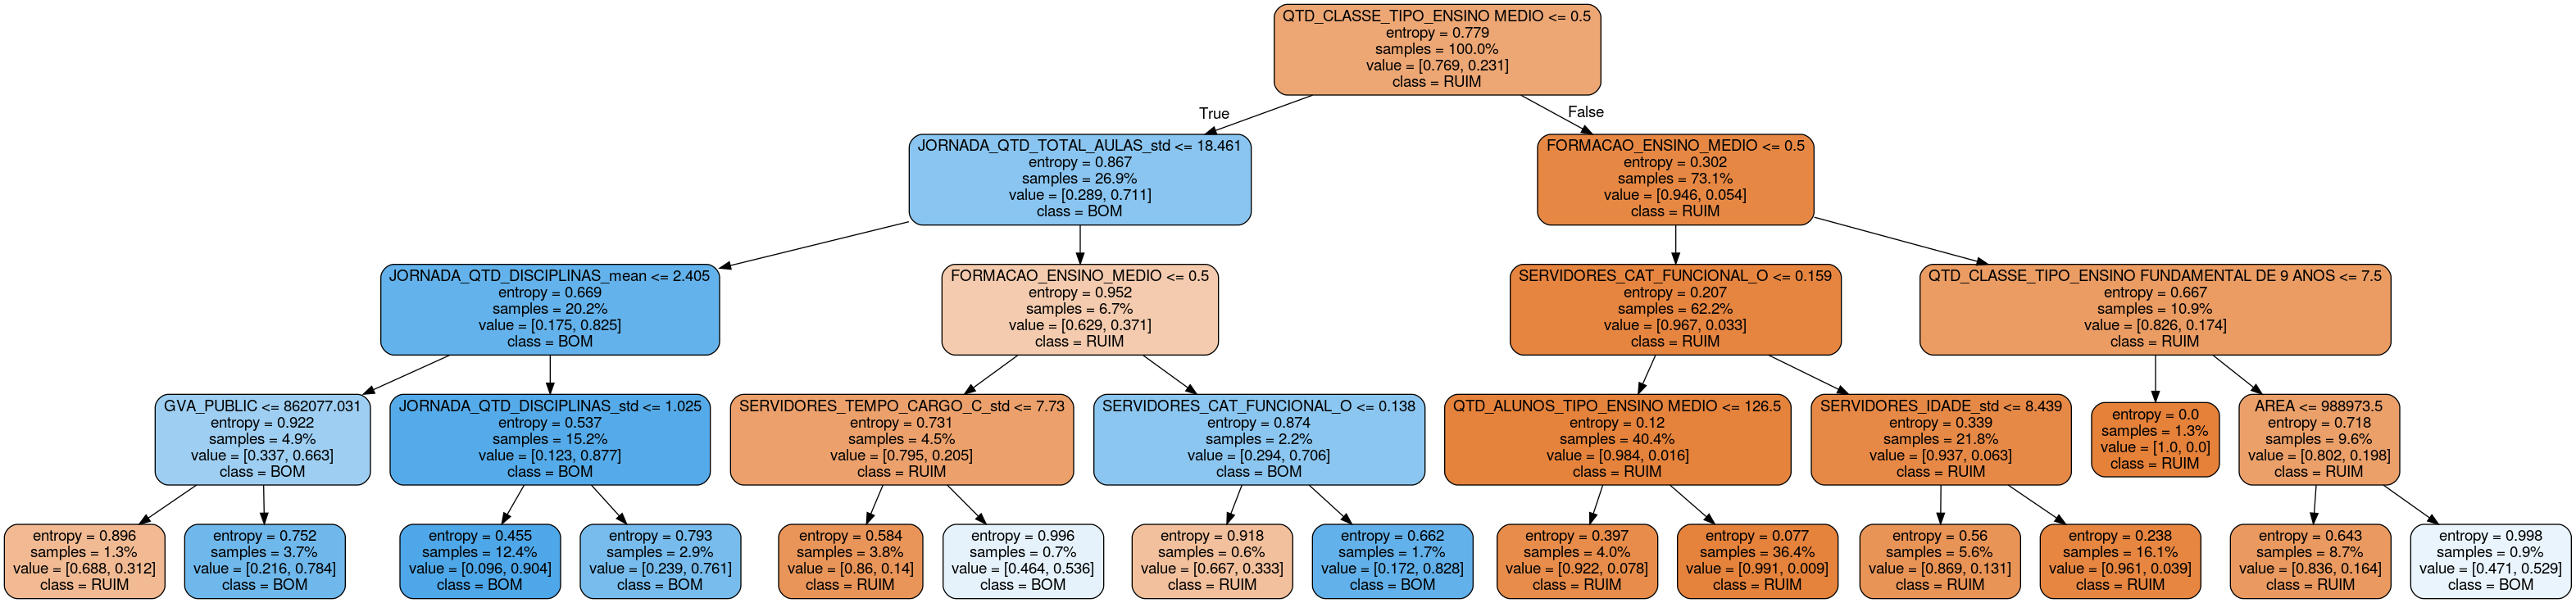

In [184]:
Image(graph.create_png())

In [101]:
print('Acc score:', accuracy_score(y_test, pred))
print('F1 score:', f1_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred))


# Acc score: 0.8898809523809523
# F1 score: 0.7739307535641547
# AUC ROC: 0.8445767195767195


# Acc score: 0.8859126984126984
# F1 score: 0.7648261758691207
# AUC ROC: 0.8379629629629629

# COM DESEMPENHO >= 0.5 (MENOR DESBALANCEAMENTO -> 0.75)
# Acc score: 0.9294736842105263
# F1 score: 0.830379746835443
# AUC ROC: 0.8893333333333333


# COM DESEMPENHO > 0.5 (MAIS DESBALANCEADA -> 0.85)
# Acc score: 0.9347368421052632
# F1 score: 0.7876712328767123
# AUC ROC: 0.8951077831946203


## COM DADOS DO ANA
# Acc score: 0.9347368421052632
# F1 score: 0.7960526315789475
# AUC ROC: 0.9133155565132294

# Acc score: 0.9242105263157895
# F1 score: 0.76
# AUC ROC: 0.8859230928075705


Acc score: 0.9315789473684211
F1 score: 0.7840531561461794
AUC ROC: 0.9023666514037403


In [ ]:
# cols = pd.DataFrame(zip(X_train.columns, model.feature_importances_)).set_index(0).sort_values(by=1, ascending=False).head(30).index
# print(cols)

# model = GradientBoostingClassifier(n_estimators=300, random_state=17)
# model.fit(X_train[cols], y_train)
# pred = model.predict(X_test[cols])

In [66]:
X_train.shape[0] / 10

379.8

In [71]:
# idx = X_train['QTD_TOTAL_ALUNOS'].sort_values(ascending=False).head(380).index
y_train.value_counts(normalize=True)

0.0    0.837283
1.0    0.162717
Name: DESEMPENHO, dtype: float64

In [77]:
idx = X_train['QTD_TOTAL_ALUNOS'].sort_values(ascending=False).head(380).index
y_train.loc[idx].value_counts(normalize=True)

0.0    0.968421
1.0    0.031579
Name: DESEMPENHO, dtype: float64

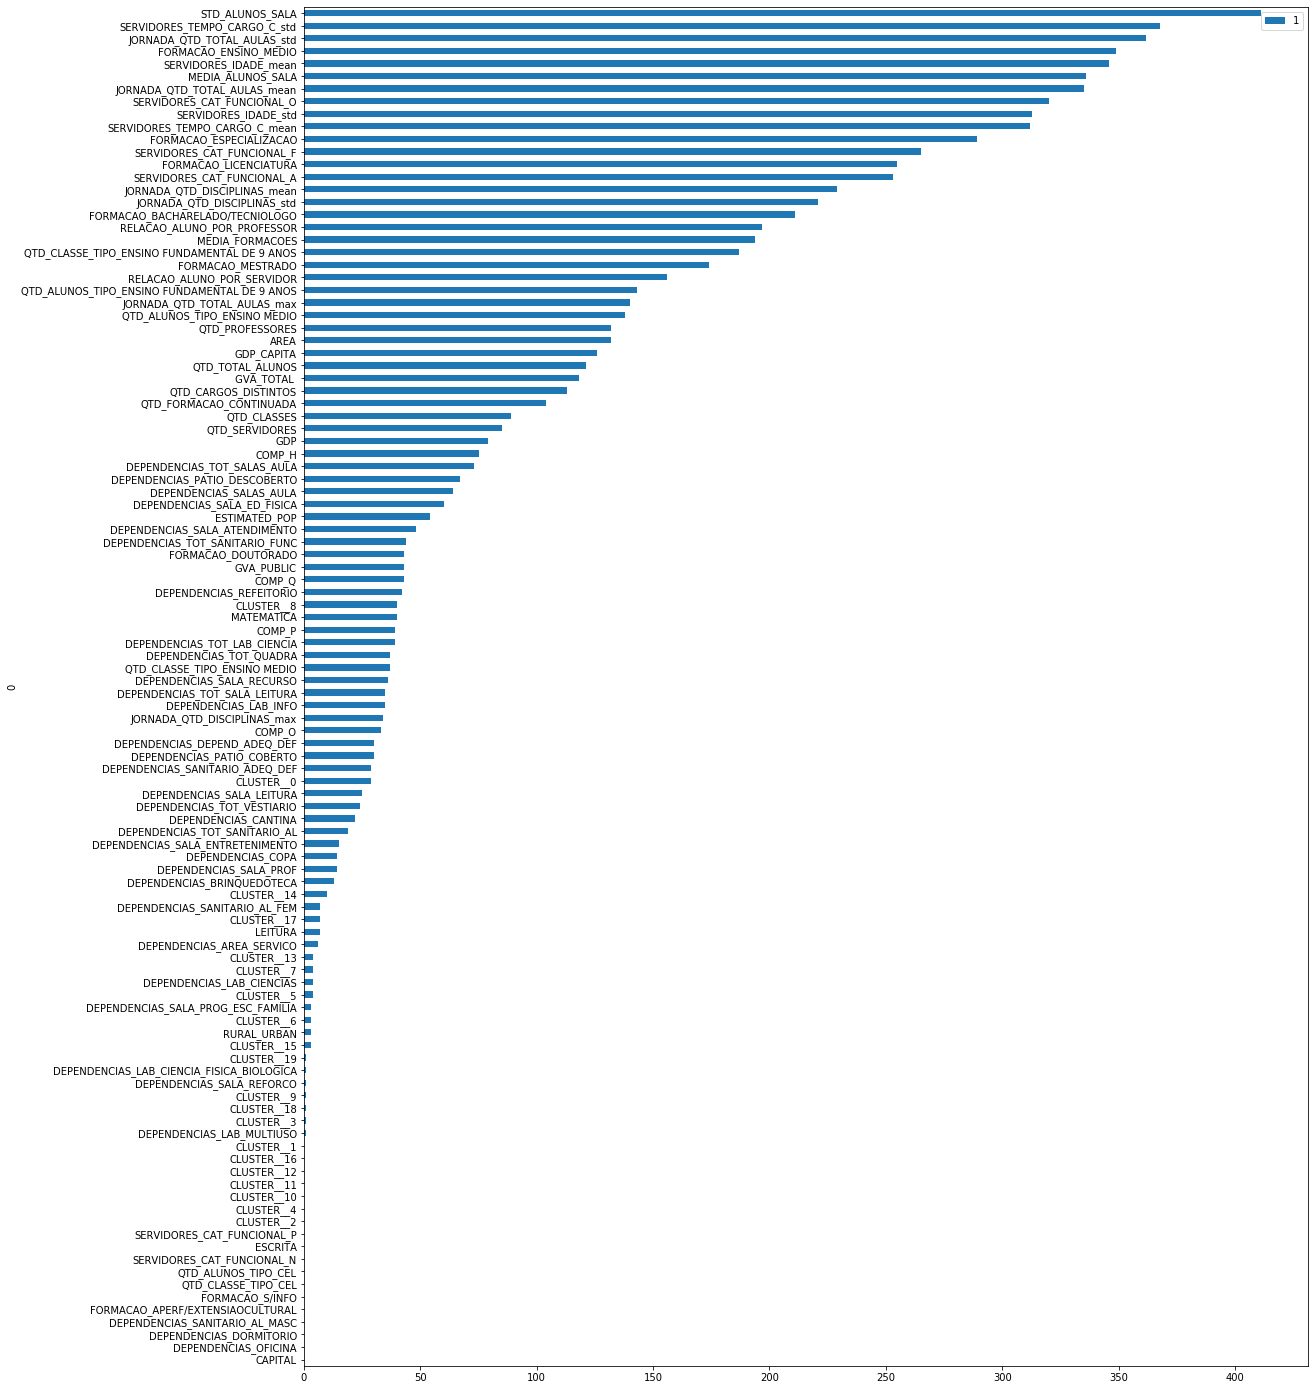

In [97]:
pd.DataFrame(zip(X_train.columns, model.feature_importances_)).set_index(0).sort_values(by=1).plot(kind='barh', figsize=(18, 25))

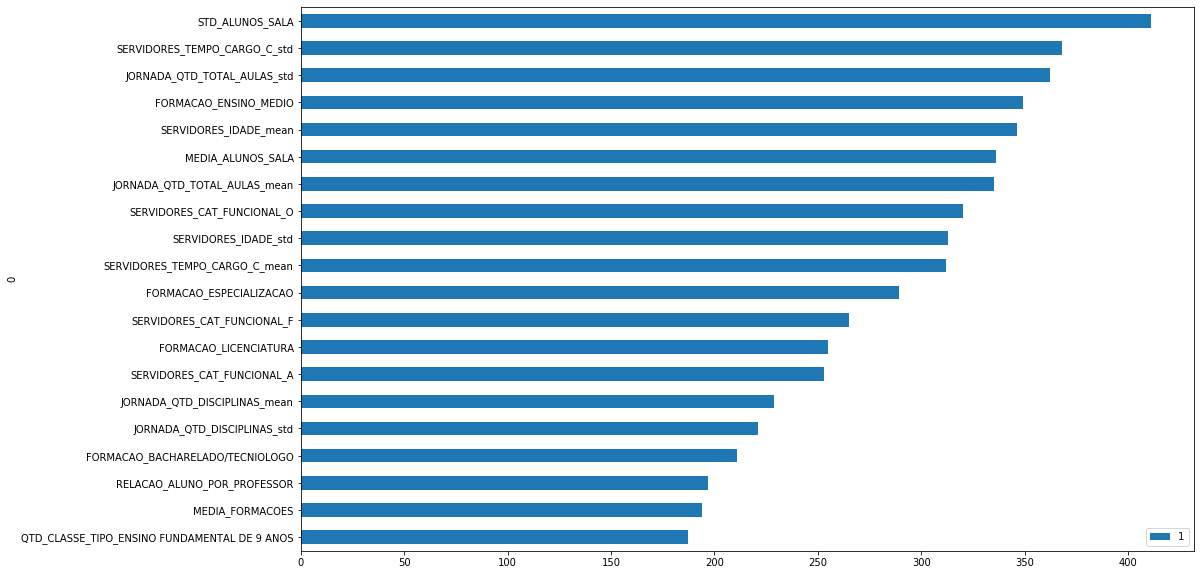

In [110]:
pd.DataFrame(zip(X_train.columns, model.feature_importances_)).set_index(0).sort_values(by=1).tail(20).plot(kind='barh', figsize=(16, 10))

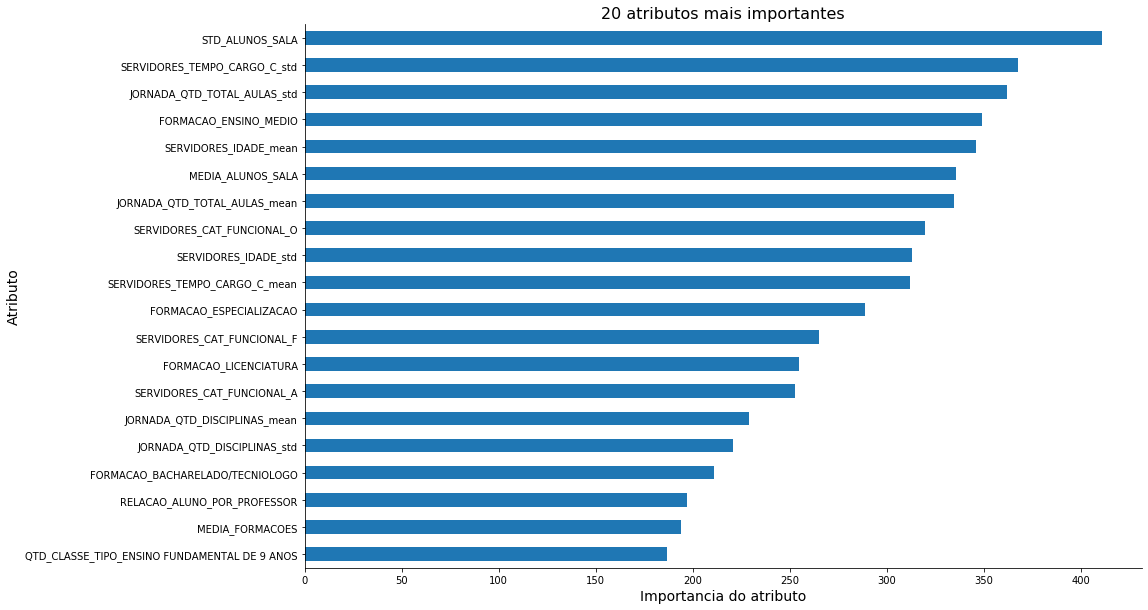

In [114]:
melhores_features = pd.DataFrame(zip(X_train.columns, model.feature_importances_)).set_index(0).sort_values(by=1).tail(20)

fig, ax = plt.subplots(figsize=(15, 10))
melhores_features.plot(kind='barh', label=None, ax=ax)

ax.set_title('20 atributos mais importantes', fontsize=16)
ax.set_ylabel('Atributo', fontsize=14)
ax.set_xlabel('Importancia do atributo', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

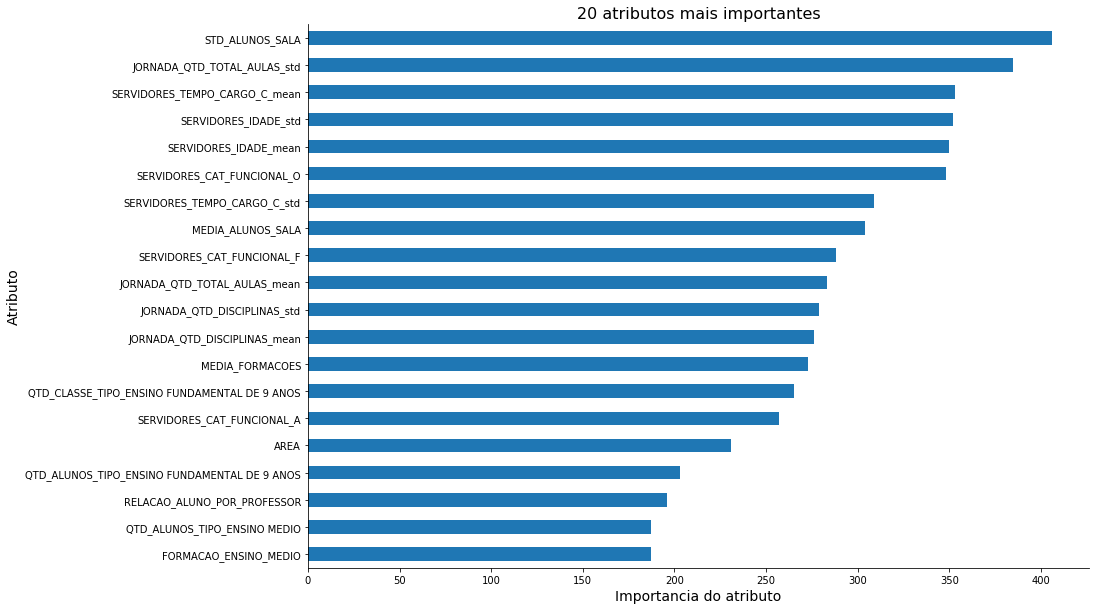

In [142]:
melhores_features = pd.DataFrame(zip(X_train.columns, model.feature_importances_)).set_index(0).sort_values(by=1).tail(20)

fig, ax = plt.subplots(figsize=(14, 10))
melhores_features.plot(kind='barh', label=None, ax=ax)

ax.set_title('20 atributos mais importantes', fontsize=16)
ax.set_ylabel('Atributo', fontsize=14)
ax.set_xlabel('Importancia do atributo', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.get_legend().remove()

## Exportar modelo

In [56]:
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Conjunto de teste

In [57]:
X_test.to_csv('../data/processed/X_test.csv')
y_test.to_csv('../data/processed/y_test.csv')

### Conjunto de dados completo (final)

In [88]:
dataset.to_csv('../data/processed/dataset_final.csv', index=False)